# Analysis of CrowdFlower job 746297: Finding drug-induced-disease relationships for Biocreative V task 3b (version 2)

2015-06-22 Tong Shu Li

Last updated 2015-06-25

Crowdflower job 746297 is the second iteration of the chemical-induced-disease relationship extraction task for Biocreative V. Version 1.0 (job 743229) did not have proper test question validation, and was therefore plagued with spammers.

This version had proper elimination of workers who chose the wrong choices.

Job 746297 was launched at 3:24 pm, Monday June 21, 2015, and completed at 8:05 pm on Monday June 21, 2015. The total cost was $54.66 USD.

Settings:
- 5 rows per page
- 5 judgements per row
- 50 cents per page
- level 1 contributor
- 50 seconds minimum per page
- worker has to maintain 70% minimum accuracy
- there were 11 test questions
- Responses to the test questions had to match exactly (all correct choices chosen, no incorrect choice chosen) in order to count as being correct

In [1]:
from __future__ import division
from collections import defaultdict
from IPython.display import Image
import pandas as pd
import matplotlib as plt

In [2]:
%matplotlib inline

In [3]:
from src.filter_data import filter_data
from src.parse_gold import parse_input
from src.parse_gold import Relation
from src.get_AUC_value import get_AUC_value
from src.aggregate_votes import aggregate_votes

### Read the results of job 746297:

In [4]:
settings = {
    "loc": "data/crowdflower/results",
    "fname": "job_746297_full_with_untrusted.csv",
    "data_subset": "normal",
    "min_accuracy": 0.7,
    "max_accuracy": 1.0
}

raw_data = filter_data(settings)

Total number of judgements collected:

In [5]:
len(raw_data)

255

In [6]:
raw_data.head()

,_unit_id,_created_at,_golden,_id,_missed,_started_at,_tainted,_channel,_trust,_worker_id,...,choice_2_ids,choice_2_label,choice_3_ids,choice_3_label,choice_4_ids,choice_4_label,form_abstract,form_title,pmid,uniq_id
0,741091284,6/22/2015 22:44:33,False,1667877616,NaN,6/22/2015 22:43:35,False,neodev,0.7273,32824409,...,C063968_induces_D016171,"<span class=""chemical"">E4031</span> contribute...",C063968_induces_D017180,"<span class=""chemical"">E4031</span> contribute...",D016593_induces_D016171,"<span class=""chemical"">terfenadine</span> cont...","1. <span class=""disease"">Torsades de pointes</...",Pharmacokinetic/pharmacodynamic assessment of ...,11569530,bcv_id_0
1,741091284,6/22/2015 23:10:22,False,1667886309,NaN,6/22/2015 23:07:02,False,elite,0.9091,30936260,...,C063968_induces_D016171,"<span class=""chemical"">E4031</span> contribute...",C063968_induces_D017180,"<span class=""chemical"">E4031</span> contribute...",D016593_induces_D016171,"<span class=""chemical"">terfenadine</span> cont...","1. <span class=""disease"">Torsades de pointes</...",Pharmacokinetic/pharmacodynamic assessment of ...,11569530,bcv_id_0
2,741091284,6/22/2015 23:10:53,False,1667886491,NaN,6/22/2015 23:08:45,False,neodev,0.7273,11064916,...,C063968_induces_D016171,"<span class=""chemical"">E4031</span> contribute...",C063968_induces_D017180,"<span class=""chemical"">E4031</span> contribute...",D016593_induces_D016171,"<span class=""chemical"">terfenadine</span> cont...","1. <span class=""disease"">Torsades de pointes</...",Pharmacokinetic/pharmacodynamic assessment of ...,11569530,bcv_id_0
3,741091284,6/22/2015 23:27:32,False,1667891825,NaN,6/22/2015 23:13:27,False,neodev,0.7143,11029942,...,C063968_induces_D016171,"<span class=""chemical"">E4031</span> contribute...",C063968_induces_D017180,"<span class=""chemical"">E4031</span> contribute...",D016593_induces_D016171,"<span class=""chemical"">terfenadine</span> cont...","1. <span class=""disease"">Torsades de pointes</...",Pharmacokinetic/pharmacodynamic assessment of ...,11569530,bcv_id_0
4,741091284,6/22/2015 23:38:33,False,1667895583,NaN,6/22/2015 23:37:10,False,prizerebel,0.8750,28853816,...,C063968_induces_D016171,"<span class=""chemical"">E4031</span> contribute...",C063968_induces_D017180,"<span class=""chemical"">E4031</span> contribute...",D016593_induces_D016171,"<span class=""chemical"">terfenadine</span> cont...","1. <span class=""disease"">Torsades de pointes</...",Pharmacokinetic/pharmacodynamic assessment of ...,11569530,bcv_id_0


### Cleaning the data:

Before we can aggregate the individual votes, we need to ensure that the responses make sense.

- "None are true" should be the only choice if selected.
- No empty choices should have been selected.

In [7]:
def check_data(data_frame):
    bad_responses = set()

    for idx, row in data_frame.iterrows():
        unit_id = row["_unit_id"]
        worker_id = row["_worker_id"]

        response = set(row["chemical_disease_relationships"].split('\n'))

        # if none are true, then it should be the only choice..
        if "none_are_true" in response and len(response) > 1:
            bad_responses.add((unit_id, worker_id))

        for i in range(5):
            column = "choice_{0}_ids".format(i)
            if (row[column] == "empty") and ("choice_{0}".format(i) in response): # clicked empty response
                bad_responses.add((unit_id, worker_id))
                
    return bad_responses

In [8]:
check_data(raw_data)

{(741091304, 30936260)}

Great, there was only one response that had an answer which didn't make sense. We can look at this answer and choose the result manually.

In [9]:
raw_data.query("_unit_id == 741091304 and _worker_id == 30936260")

,_unit_id,_created_at,_golden,_id,_missed,_started_at,_tainted,_channel,_trust,_worker_id,...,choice_2_ids,choice_2_label,choice_3_ids,choice_3_label,choice_4_ids,choice_4_label,form_abstract,form_title,pmid,uniq_id
101,741091304,6/22/2015 22:55:07,False,1667881387,NaN,6/22/2015 22:49:15,False,elite,0.9091,30936260,...,D025101_induces_D007676,"<span class=""chemical"">vitamin B6</span> contr...",empty,<strong>Do not</strong> choose this choice.,empty,<strong>Do not</strong> choose this choice.,Two patients with similar clinical features ar...,"Serial <span class=""disease"">epilepsy</span> c...",2265898,bcv_id_20


In [10]:
raw_data.loc[101]["chemical_disease_relationships"]

'choice_1\nnone_are_true'

This contributor chose both "none are true" and the second choice, so we will manually change it to "none are true" because that overrides the other choice.

In [11]:
raw_data.loc[101, "chemical_disease_relationships"] = "none_are_true"

In [12]:
raw_data.loc[101]["chemical_disease_relationships"]

'none_are_true'

In [13]:
check_data(raw_data)

set()

Now that the data have been cleaned up, we can proceed to the analysis.

## Aggregation scheme:

1. Aggregate on unique id (one subset of the N x M expansion of all drug-disease pairs). Normalize scores by the total trust score of all workers who worked on that work unit.
2. Aggregate above results on PMID
3. Return a ranked list of drug-disease pairs for each PMID
4. Perform ROC analysis on ranked list using normalized threshold.

Consider the case where we have M choices voted upon by N people. One of the M choices is that "None of the given choices are true". How do we aggregate votes?

Since the M choices represent the set of all possible drug-disease relationships in an abstract, we want a list of the possible relationships for any one work unit, with a score of how confident we are that that relationship might be true. Notice that picking the top answer is not the right approach because we would lose lots of information.

With these considerations in mind, the voting scheme will be as follows:
1. Choices which a person does not select are untouched.
2. Choices which a person explicitly picks gets their trust score added to that choice.
3. The "none of the above" choice applies the negative trust score to every other choice.

Finally, all the choices are sorted by decreasing score. Negative scores represent cases where more people said that choice was wrong than people who said it was right.

In [14]:
def generate_results(data_frame, penalize_unchosen = False):
    results = []
    for pmid, pmid_group in data_frame.groupby("pmid"):
        temp = []
        for uniq_id, group in pmid_group.groupby("uniq_id"):
            scores = aggregate_votes(uniq_id, group, penalize_unchosen)
            temp.append(scores)

        df = pd.concat(temp)
        if not df.empty:
            df = df.sort("normalized_score", axis = 0, ascending = False)
            df["pmid"] = pmid
            results.append(df)
            
    return pd.concat(results)

In [15]:
results = generate_results(raw_data)

In [16]:
results.head()

,id_pair,normalized_score,uniq_id,unit_id,pmid
3,D005839_induces_D007674,0.794784,bcv_id_45,741091329,1130930
1,D002512_induces_D007674,0.770023,bcv_id_46,741091330,1130930
2,D005839_induces_D007683,0.605403,bcv_id_45,741091329,1130930
0,D002512_induces_D007683,0.594662,bcv_id_46,741091330,1130930
1,D005839_induces_D009846|D051437,0.420701,bcv_id_45,741091329,1130930


In [17]:
results_penalized = generate_results(raw_data, penalize_unchosen = True)

In [18]:
results_penalized.head()

,id_pair,normalized_score,uniq_id,unit_id,pmid
3,D005839_induces_D007674,0.589568,bcv_id_45,741091329,1130930
1,D002512_induces_D007674,0.540046,bcv_id_46,741091330,1130930
2,D005839_induces_D007683,0.210806,bcv_id_45,741091329,1130930
0,D002512_induces_D007683,0.189325,bcv_id_46,741091330,1130930
1,D005839_induces_D009846|D051437,-0.158597,bcv_id_45,741091329,1130930


We want to see if the aggregation scheme makes a difference on our F-score.

Now that we have our results table, listing the drug-disease relationships with a confidence score, we can perform a ROC analysis on the score as a predictor. To generate our ROC curve, we will:

1. Use the gold standard to look up whether each disease pair id was a true positive or not.
2. Use the R ROCR package to generate the ROC curve.

In [19]:
training_data = parse_input("data/training", "CDR_TrainingSet.txt")

In [20]:
used_pmids = set(raw_data["pmid"].unique())
print len(used_pmids)
used_pmids

30


{1130930,
 1378968,
 1835291,
 2096243,
 2265898,
 2375138,
 2515254,
 3800626,
 6666578,
 6692345,
 7449470,
 7582165,
 8590259,
 8595686,
 9522143,
 10520387,
 10835440,
 11135224,
 11569530,
 12041669,
 12198388,
 15602202,
 15632880,
 16167916,
 16337777,
 17241784,
 17261653,
 17931375,
 18631865,
 19269743}

### Generate the gold relations:

In [21]:
gold_relations = dict()
for paper in training_data:
    if int(paper.pmid) in used_pmids:
        gold_relations[paper.pmid] = paper.relations

Total number of gold relationships for the 30 papers:

In [22]:
sum(map(len, gold_relations.values()))

64

In [23]:
def in_gold(pmid, annot):
    """
    Sometimes a drug-disease relationship will contain
    only one identifier for each concept, and the id
    won't show up by itself in the annotations, but as
    part of a complex annotation.
    
    For example, in PMID 1130930, there is a relation
    between D002512 and D009846, but D009846 is not the
    identifier for any annotation. The only annotation
    with D009846 is D009846|D051437, and therefore an
    exact match is not the right way to check for equality.
    """
    drug_ids = set(annot.drug.split('|'))
    disease_ids = set(annot.disease.split('|'))
    for gold_rel in gold_relations[str(pmid)]:
        if gold_rel.drug in drug_ids and gold_rel.disease in disease_ids:
            return True
        
    return False

In [24]:
def determine_truth(data_frame):
    """
    Determines if each choice is in the gold.
    """
    is_in_gold = []
    for idx, row in results.iterrows():
        pmid = row["pmid"]
        temp = row["id_pair"].split("_induces_")
        annot = Relation(temp[0], temp[1])

        is_in_gold.append(int(in_gold(pmid, annot)))
        
    return is_in_gold

In [25]:
results["in_gold"] = determine_truth(results)

In [26]:
results_penalized["in_gold"] = determine_truth(results_penalized)

In [27]:
results

,id_pair,normalized_score,uniq_id,unit_id,pmid,in_gold
3,D005839_induces_D007674,0.794784,bcv_id_45,741091329,1130930,0
1,D002512_induces_D007674,0.770023,bcv_id_46,741091330,1130930,0
2,D005839_induces_D007683,0.605403,bcv_id_45,741091329,1130930,1
0,D002512_induces_D007683,0.594662,bcv_id_46,741091330,1130930,1
1,D005839_induces_D009846|D051437,0.420701,bcv_id_45,741091329,1130930,1
0,D002512_induces_D009846|D051437,0.389918,bcv_id_45,741091329,1130930,1
2,D002512_induces_D051437,0.180698,bcv_id_46,741091330,1130930,0
4,D005839_induces_D051437,0.000000,bcv_id_45,741091329,1130930,0
0,D008094_induces_D007674,0.816750,bcv_id_6,741091290,1378968,0
2,D008094_induces_D006973,0.816750,bcv_id_6,741091290,1378968,1


### Perform a ROC analysis on all 30 abstracts:

In [28]:
fname = "data/roc/job_746297_roc.png"
title = "ROC curve for all 30 abstracts of job 746297"
get_AUC_value(results, "normalized_score", "in_gold", fname, title)

0.904063492063492

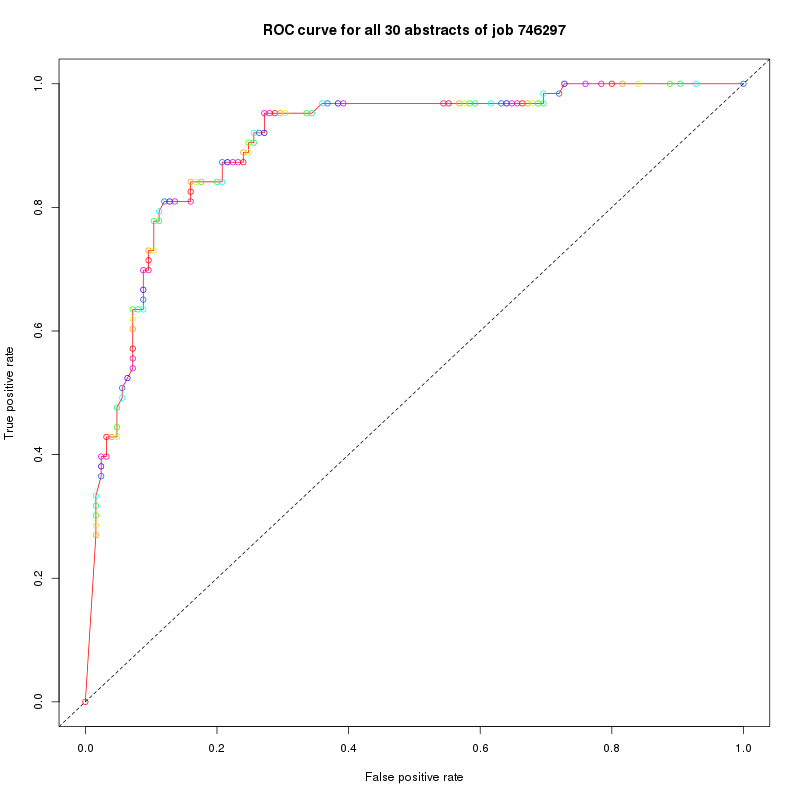

In [29]:
Image(filename = fname) 

We see that the AUC for our run was 0.89. We now want to know at which normalized voting score threshold value we achieve the highest F score, and what the precision and recall are like at that point.

In [30]:
fname = "data/roc/job_746297_penalize_unchosen.png"
title = "ROC curve for all 30 abstracts of job 746297\nUnchosen choices are penalized"
get_AUC_value(results_penalized, "normalized_score", "in_gold", fname, title)

0.9046984126984129

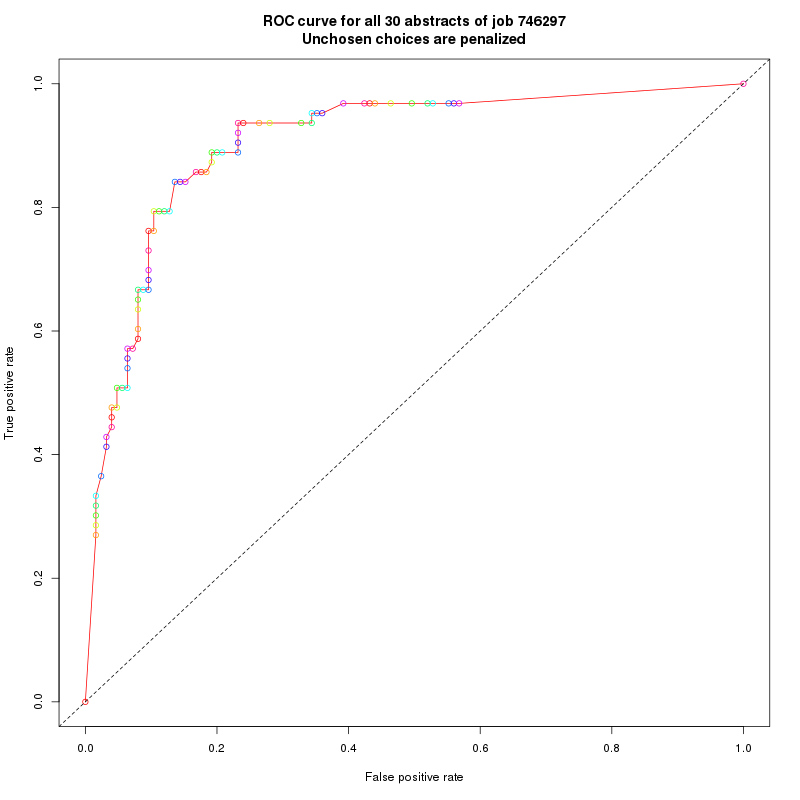

In [31]:
Image(filename = fname)

---

### Function for determining F-score:

In [32]:
def F_score(precision, recall):
    return 2 * (precision * recall) / (precision + recall)
    
def max_F_score(data_frame):
    """
    Given the results dataframe for one or many PMIDs, with the in_gold
    column already determined, this function determines the max
    F score with respect to the gold standard and the value of
    the normalized voting score at which the max F score is achieved.
    """
    EPSILON = 0.0000001
    
    max_f_score = 0
    best_threshold = 9999
    best_res = (-1, -1)
    
    for threshold in data_frame["normalized_score"].unique():
        sub = data_frame.query("normalized_score > {0} or -{1} <= normalized_score - {0} <= {1}".format(threshold, EPSILON))
        
        recall = sum(sub["in_gold"]) / sum(data_frame["in_gold"])
        precision = sum(sub["in_gold"]) / len(sub)
        
        f_score = F_score(precision, recall)
        
        if f_score > max_f_score:
            max_f_score = f_score
            best_res = (precision, recall)
            best_threshold = threshold
            
    return (max_f_score, best_res, best_threshold)

In [33]:
max_F_score(results)

(0.79069767441860461,
 (0.77272727272727271, 0.80952380952380953),
 0.40719029820645886)

In [34]:
max_F_score(results_penalized)

(0.79699248120300747,
 (0.75714285714285712, 0.84126984126984128),
 -0.15859725163768901)

This shows us that if we take all choices with normalized voting scores above 0.407, we achieve a F-score of 0.79, with a precision of 0.77 and a recall of 0.809.

When we use the aggregation scheme where unchosen choices are penalized, then we see that we gain a bit more recall at the cost of precision. Overall the results are not too different.

---

### We can look at each paper individually and examine the F-score and AUC value to identify individual papers that the crowd is struggling with:

In [35]:
for pmid, group in results.groupby("pmid"):
    if sum(group["in_gold"]) != len(gold_relations[str(pmid)]):
        print pmid

1835291


In [36]:
results.query("pmid == 1835291")

,id_pair,normalized_score,uniq_id,unit_id,pmid,in_gold
0,D013806_induces_D002318|D005767,0.821600,bcv_id_33,741091317,1835291,1
1,D013806_induces_D029424,0.401393,bcv_id_33,741091317,1835291,0
3,D009241_induces_D029424,0.401393,bcv_id_33,741091317,1835291,0
2,D009241_induces_D002318|D005767,0.000000,bcv_id_33,741091317,1835291,0


The problem here is that there was one disease which had a composite id, but in the gold standard it is listed as having two gold relations, one for each of the individual components of the id. Therefore we will only ever be able to get 50% recall for this problem because the crowd only makes one choice.

### What is the AUC for each paper?

In [37]:
auc = dict()
for pmid, group in results.groupby("pmid"):
    auc[pmid] = get_AUC_value(group, "normalized_score", "in_gold")    

In [38]:
res = [(key, val) for key, val in auc.items()]
res = sorted(res, key = lambda x: -x[1])
res

[(15602202, 1.0),
 (1835291, 1.0),
 (15632880, 1.0),
 (2265898, 1.0),
 (3800626, 1),
 (8590259, 1.0),
 (2515254, 1.0),
 (17241784, 1.0),
 (18631865, 1.0),
 (10520387, 1.0),
 (12041669, 1.0),
 (19269743, 1),
 (6666578, 1.0),
 (9522143, 1.0),
 (8595686, 1.0),
 (16167916, 1.0),
 (17931375, 1),
 (10835440, 1.0),
 (2096243, 1.0),
 (17261653, 1.0),
 (1378968, 0.9259259259259259),
 (7582165, 0.85),
 (11569530, 0.8333333333333333),
 (12198388, 0.7564102564102563),
 (16337777, 0.75),
 (11135224, 0.6481481481481481),
 (6692345, 0.5625),
 (1130930, 0.5),
 (2375138, 0.25),
 (7449470, 0.0)]

### What is the F-score for each paper?

In [39]:
best_f = dict()
for pmid, group in results.groupby("pmid"):
    best_f[pmid] = max_F_score(group)
    
temp = [(key, val) for key, val in best_f.items()]
temp = sorted(temp, key = lambda x: -x[1][0])
temp

[(15602202, (1.0, (1.0, 1.0), 1.0)),
 (1835291, (1.0, (1.0, 1.0), 0.82160027472527464)),
 (15632880, (1.0, (1.0, 1.0), 1.0)),
 (2265898, (1.0, (1.0, 1.0), 0.63517343432570039)),
 (3800626, (1.0, (1.0, 1.0), 0.21511737341687059)),
 (8590259, (1.0, (1.0, 1.0), 0.56677785859396557)),
 (2515254, (1.0, (1.0, 1.0), 1.0)),
 (17241784, (1.0, (1.0, 1.0), 0.38747440014158935)),
 (18631865, (1.0, (1.0, 1.0), 0.18970042089626146)),
 (10520387, (1.0, (1.0, 1.0), 0.78511787819253442)),
 (12041669, (1.0, (1.0, 1.0), 1.0)),
 (19269743, (1.0, (1.0, 1.0), 1.0)),
 (6666578, (1.0, (1.0, 1.0), 1.0)),
 (9522143, (1.0, (1.0, 1.0), 0.60625453763209547)),
 (8595686, (1.0, (1.0, 1.0), 0.81603218210361061)),
 (16167916, (1.0, (1.0, 1.0), 0.63350046612411504)),
 (17931375, (1.0, (1.0, 1.0), 1.0)),
 (10835440, (1.0, (1.0, 1.0), 1.0)),
 (2096243, (1.0, (1.0, 1.0), 0.60504325963173844)),
 (17261653, (1.0, (1.0, 1.0), 0.64005139963213986)),
 (7582165,
  (0.88888888888888895, (0.80000000000000004, 1.0), 0.420701374181

In [40]:
total_f = 0
for pmid, val in best_f.items():
    total_f += val[0]
    
print total_f / 30

0.921158451685


If we use one voting threshold for every paper, then our F-score for the entire dataset is 0.79. However we see that on some papers, the crowd performed very well, while on others did they more poorly. If we had some way of adjusting the cutoff threshold for each paper individually (such as lowering the threshold based on how difficult the crowd thought the paper was), then we can get a much better F-score of 0.92. Of course, we need a good way of determining how we should adjust the cutoff threshold for each paper.

### A summary of the results:

In [41]:
data = defaultdict(list)
for paper in training_data:
    if int(paper.pmid) in used_pmids:
        data["pmid"].append(paper.pmid)
        data["length"].append(len(paper.title) + len(paper.abstract))
        data["auc"].append(auc[int(paper.pmid)])
        data["f_score"].append(best_f[int(paper.pmid)][0])
        data["precision"].append(best_f[int(paper.pmid)][1][0])
        data["recall"].append(best_f[int(paper.pmid)][1][1])
        
data = pd.DataFrame(data)

In [42]:
data

,auc,f_score,length,pmid,precision,recall
0,0.925926,0.857143,1891,1378968,0.750000,1.000000
1,1.000000,1.000000,866,2515254,1.000000,1.000000
2,1.000000,1.000000,842,3800626,1.000000,1.000000
3,0.562500,0.666667,1280,6692345,0.500000,1.000000
4,1.000000,1.000000,1177,1835291,1.000000,1.000000
5,0.833333,0.857143,1754,11569530,0.750000,1.000000
6,1.000000,1.000000,526,12041669,1.000000,1.000000
7,0.756410,0.800000,2260,12198388,1.000000,0.666667
8,1.000000,1.000000,1482,16167916,1.000000,1.000000
9,1.000000,1.000000,1066,17241784,1.000000,1.000000


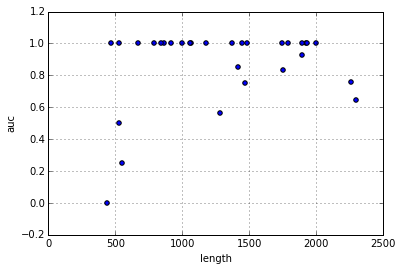

In [43]:
data.plot(kind = "scatter", x = "length", y = "auc")

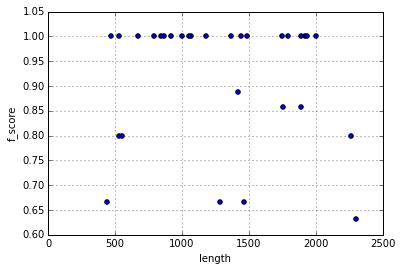

In [44]:
data.plot(kind = "scatter", x = "length", y = "f_score")

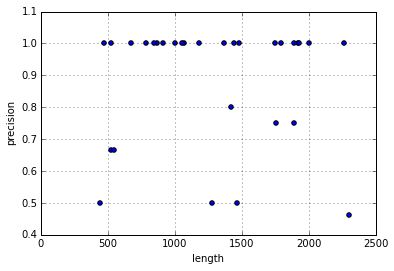

In [45]:
data.plot(kind = "scatter", x = "length", y = "precision")

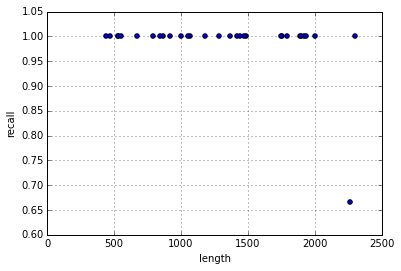

In [46]:
data.plot(kind = "scatter", x = "length", y = "recall")

These data suggest that there doesn't seem to be a correlation between how long the abstract was and how well the crowd performed in any of the metrics.